# Advanced Model Evaluation: Improving Cyber Risk Prediction with Regularization

### Project Context (Week 8)

This notebook executes the Week 8 objectives by extending the baseline model established in Week 7. The focus shifts from basic modeling to **advanced regression techniques** and **rigorous engineering evaluation**.

**Objective:** To investigate whether advanced regression methods (specifically Ridge/Lasso or Polynomial Regression) can **improve the predictive performance** and **model robustness** compared to the Week 7 Linear Regression baseline ($R^2=0.8486$). This involves calculating new evaluation metrics like **MAE**.

**Data Source:** Data obtained from the research study: [Quantification of the Global Cyber Threat Landscape: An ML-Based Assessment](https://www.mdpi.com/2078-2489/15/4/199).

**Target Variable:** The target variable for all models remains the **Log-transformed Local Infection** rate. This section will conclude with a **reflection** on the best model and the importance of efficient code **refactoring** (the engineering mindset).

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  IPython.display import display
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures

### Data Loading and Initial Checks

In [2]:
# Load data
df = pd.read_csv('cyber_data.csv')
df

,AttackDate,Country,Spam,Ransomware,Local Infection,Exploit,Malicious Mail,Network Attack,On Demand Scan,Web Threat,Rank Spam,Rank Ransomware,Rank Local Infection,Rank Exploit,Rank Malicious Mail,Rank Network Attack,Rank On Demand Scan,Rank Web Threat
0,11/10/2022 0:00,Arab Republic of Egypt,0.00090,0.00013,0.01353,0.00013,0.00287,0.01007,0.01148,0.01708,68,47,85,176,34,11,78,53
1,11/10/2022 0:00,Argentine Republic,0.00601,0.00006,0.00575,0.00035,0.00058,0.00095,0.00482,0.00974,27,86,174,128,140,138,174,160
2,11/10/2022 0:00,Aruba,NaN,NaN,0.01384,NaN,0.00092,NaN,0.00830,0.00554,162,143,82,186,104,187,119,190
3,11/10/2022 0:00,Bailiwick of Guernsey,NaN,NaN,0.00546,0.00273,NaN,0.00091,0.00546,0.01001,162,143,179,1,186,141,164,159
4,11/10/2022 0:00,Bailiwick of Jersey,0.00003,NaN,0.00774,0.00101,0.00067,NaN,0.00707,0.01145,138,143,150,31,133,187,137,146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77618,11/12/2023 0:00,United Arab Emirates,0.00064,0.00009,0.00901,0.00057,0.00198,0.00149,0.00892,0.01274,86,37,100,43,2,40,42,87
77619,11/12/2023 0:00,United Kingdom of Great Britain and Northern I...,0.01292,0.00003,0.00428,0.00084,0.00021,0.00045,0.00382,0.01205,12,89,173,14,97,139,171,100
77620,11/12/2023 0:00,United Mexican States,0.00500,0.00004,0.00870,0.00019,0.00035,0.00106,0.00772,0.00834,34,77,106,122,65,68,74,152
77621,11/12/2023 0:00,United Republic of Tanzania,0.00030,0.00002,0.01201,0.00031,0.00028,0.00091,0.00717,0.01145,101,116,54,83,77,83,92,114


### Data Cleaning

In [3]:
#Make a copy of the dataframe for cleaning and to serve as a savepoint
df_cleaned = df.copy()

In [4]:
cols_to_drop = [x for x in df_cleaned.columns if 'Rank' in x]
cols_to_drop = cols_to_drop + ['On Demand Scan']
cols_to_drop

['Rank Spam',
 'Rank Ransomware',
 'Rank Local Infection',
 'Rank Exploit',
 'Rank Malicious Mail',
 'Rank Network Attack',
 'Rank On Demand Scan',
 'Rank Web Threat',
 'On Demand Scan']

In [5]:
df_cleaned = df_cleaned.drop(columns = cols_to_drop, axis = 1)
df_cleaned.columns

Index(['AttackDate', 'Country', 'Spam', 'Ransomware', 'Local Infection',
       'Exploit', 'Malicious Mail', 'Network Attack', 'Web Threat'],
      dtype='object')

##### Renaming of variables

In [6]:
"""Column names before cleaning:"""
print(df.columns)
print("-" * 50)

# Fix the names by replacing spaces with underscore
fixed_names = {col: col.replace(' ', '_') for col in df_cleaned.columns}
df_cleaned.rename(columns = fixed_names, inplace = True)

"""Column names after cleaning:"""
print(df_cleaned.columns)

Index(['AttackDate', 'Country', 'Spam', 'Ransomware', 'Local Infection',
       'Exploit', 'Malicious Mail', 'Network Attack', 'On Demand Scan',
       'Web Threat', 'Rank Spam', 'Rank Ransomware', 'Rank Local Infection',
       'Rank Exploit', 'Rank Malicious Mail', 'Rank Network Attack',
       'Rank On Demand Scan', 'Rank Web Threat'],
      dtype='object')
--------------------------------------------------
Index(['AttackDate', 'Country', 'Spam', 'Ransomware', 'Local_Infection',
       'Exploit', 'Malicious_Mail', 'Network_Attack', 'Web_Threat'],
      dtype='object')


##### Handling of Nulls

In [7]:
"""
Earlier, we found that the columns below have nulls. 
To determine the best approach on how to handle this, we need to: 
- Consider the level of completeness first to see if we can drop all rows where there are nulls.
- Check if we can apply imputation and which type of imputation.
"""

null_list = [
            'Spam',
            'Ransomware',
            'Local_Infection',
            'Exploit',
            'Malicious_Mail',
            'Network_Attack',
            'Web_Threat',
]
null_list

# Make a copy of the df where only those in null_list exist for ease of use.
df_nulls = df_cleaned[null_list] 

In [8]:
# Imputing using median
for col in null_list:
    median_val = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_val)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77623 entries, 0 to 77622
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AttackDate       77623 non-null  object 
 1   Country          77623 non-null  object 
 2   Spam             77623 non-null  float64
 3   Ransomware       77623 non-null  float64
 4   Local_Infection  77623 non-null  float64
 5   Exploit          77623 non-null  float64
 6   Malicious_Mail   77623 non-null  float64
 7   Network_Attack   77623 non-null  float64
 8   Web_Threat       77623 non-null  float64
dtypes: float64(7), object(2)
memory usage: 5.3+ MB


### Feature Engineering

Since the data cleaning has been completed, we'll need to look at the following for feature engineering:
- Encoding of Country
- Date and time features creation: We can use AttackDate here and encode it by year, month, and day to see if there are seasonal patterns or trends on the attacks. We can also try to extract the day of the week and time features to know when the attacks usually happen.
- Interaction Features and Polynomial Features
    - Looking at the data that we have, there are a lot of features with extreme right-skewness which will potentially lead to a higher leverage point that skews the model's coefficients and residuals. 
    - Plan is to apply log transformation on highly skewed features and on the target variable to normalize the distributions and make the assumption of normally distributed residuals for linear regression.

##### Encoding of Country

In [9]:
# Get the count of columns to be added
data_ohe = df_cleaned.copy()
len(data_ohe['Country'].unique())-1 # k-1

224

In [10]:
# Encode the countries
country_dummies = pd.get_dummies(data_ohe['Country'], drop_first = True)
country_dummies

,Antarctica,Antigua and Barbuda,Arab Republic of Egypt,Argentine Republic,Aruba,Bailiwick of Guernsey,Bailiwick of Jersey,Barbados,Belize,Bermuda,...,Union of the Comoros,United Arab Emirates,United Kingdom of Great Britain and Northern Ireland,United Mexican States,United Republic of Tanzania,United States of America,Vatican City State,Virgin Islands,Virgin Islands of the United States,Åland Islands
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77618,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
77619,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
77620,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
77621,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [11]:
# Concatenate and delete 'Country' column
df_cleaned = df_cleaned.reset_index(drop=True)
country_dummies = country_dummies.reset_index(drop=True)
df_cleaned = pd.concat([df_cleaned, country_dummies], axis=1)
df_cleaned = df_cleaned.drop('Country', axis=1)
df_cleaned


,AttackDate,Spam,Ransomware,Local_Infection,Exploit,Malicious_Mail,Network_Attack,Web_Threat,Antarctica,Antigua and Barbuda,...,Union of the Comoros,United Arab Emirates,United Kingdom of Great Britain and Northern Ireland,United Mexican States,United Republic of Tanzania,United States of America,Vatican City State,Virgin Islands,Virgin Islands of the United States,Åland Islands
0,11/10/2022 0:00,0.00090,0.00013,0.01353,0.00013,0.00287,0.01007,0.01708,False,False,...,False,False,False,False,False,False,False,False,False,False
1,11/10/2022 0:00,0.00601,0.00006,0.00575,0.00035,0.00058,0.00095,0.00974,False,False,...,False,False,False,False,False,False,False,False,False,False
2,11/10/2022 0:00,0.00059,0.00007,0.01384,0.00039,0.00092,0.00129,0.00554,False,False,...,False,False,False,False,False,False,False,False,False,False
3,11/10/2022 0:00,0.00059,0.00007,0.00546,0.00273,0.00073,0.00091,0.01001,False,False,...,False,False,False,False,False,False,False,False,False,False
4,11/10/2022 0:00,0.00003,0.00007,0.00774,0.00101,0.00067,0.00129,0.01145,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77618,11/12/2023 0:00,0.00064,0.00009,0.00901,0.00057,0.00198,0.00149,0.01274,False,False,...,False,True,False,False,False,False,False,False,False,False
77619,11/12/2023 0:00,0.01292,0.00003,0.00428,0.00084,0.00021,0.00045,0.01205,False,False,...,False,False,True,False,False,False,False,False,False,False
77620,11/12/2023 0:00,0.00500,0.00004,0.00870,0.00019,0.00035,0.00106,0.00834,False,False,...,False,False,False,True,False,False,False,False,False,False
77621,11/12/2023 0:00,0.00030,0.00002,0.01201,0.00031,0.00028,0.00091,0.01145,False,False,...,False,False,False,False,True,False,False,False,False,False


##### Date and time features creation

First we need to convert AttackDate to datetime then we will extract the basic temporal features:
- Year
- Month
- Date

Then extract the time-based features:
- Day of week
- Hour
- Time of day

For Time of Day, I'll split it into the following categories and definitions:
- Morning - 5AM to before 12NN
- Afternoon - 12NN to before 5PM
- Evening - 5PM to before 9PM
- Night - 9PM to before 5AM
This segregation allows us to determine when the time of attack were and allows the model to uncover trends in the data.

In [12]:
# Convert AttackDate to datetime format
df_cleaned['AttackDate'] = pd.to_datetime(df_cleaned['AttackDate'], dayfirst = True)

In [13]:
# Basic temporal features creation
df_cleaned['Year'] = df_cleaned['AttackDate'].dt.year
df_cleaned['Month'] = df_cleaned['AttackDate'].dt.month
df_cleaned['Day'] = df_cleaned['AttackDate'].dt.day

In [14]:
# Time-based features creation

df_cleaned['Day_of_Week'] = df_cleaned['AttackDate'].dt.dayofweek
df_cleaned['Hour'] = df_cleaned['AttackDate'].dt.hour

def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'
    
df_cleaned['Time_of_Day'] = df_cleaned['Hour'].apply(get_time_of_day)

In [15]:
for i in ['Year', 'Month', 'Day', 'Day_of_Week', 'Hour', 'Time_of_Day']:
    display(df_cleaned[i].value_counts())
    print('-' *100)

Year
2023    62124
2022    15499
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------


Month
11    11077
10     9535
12     8159
4      5929
1      5912
5      5729
2      5560
3      5539
7      5533
6      5328
9      4775
8      4547
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------


Day
7     2789
18    2785
11    2779
10    2779
4     2778
21    2774
28    2769
9     2769
15    2764
16    2752
6     2596
13    2589
20    2585
22    2578
19    2578
8     2577
17    2572
3     2570
27    2568
5     2401
14    2398
12    2389
24    2369
23    2367
2     2366
1     2358
29    2346
25    2175
26    1975
30    1959
31    1569
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------


Day_of_Week
0    11696
1    11500
4    11298
3    11268
2    11239
5    10496
6    10126
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------


Hour
0    77623
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------


Time_of_Day
Night    77623
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------


We can see that Hour and Time_of_Day has no categories as timestamps don't exist in the data. We should drop these along with the AttackDate column.

In [16]:
df_cleaned = df_cleaned.drop(['AttackDate', 'Hour', 'Time_of_Day'], axis=1)
df_cleaned

,Spam,Ransomware,Local_Infection,Exploit,Malicious_Mail,Network_Attack,Web_Threat,Antarctica,Antigua and Barbuda,Arab Republic of Egypt,...,United Republic of Tanzania,United States of America,Vatican City State,Virgin Islands,Virgin Islands of the United States,Åland Islands,Year,Month,Day,Day_of_Week
0,0.00090,0.00013,0.01353,0.00013,0.00287,0.01007,0.01708,False,False,True,...,False,False,False,False,False,False,2022,10,11,1
1,0.00601,0.00006,0.00575,0.00035,0.00058,0.00095,0.00974,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
2,0.00059,0.00007,0.01384,0.00039,0.00092,0.00129,0.00554,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
3,0.00059,0.00007,0.00546,0.00273,0.00073,0.00091,0.01001,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
4,0.00003,0.00007,0.00774,0.00101,0.00067,0.00129,0.01145,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77618,0.00064,0.00009,0.00901,0.00057,0.00198,0.00149,0.01274,False,False,False,...,False,False,False,False,False,False,2023,12,11,0
77619,0.01292,0.00003,0.00428,0.00084,0.00021,0.00045,0.01205,False,False,False,...,False,False,False,False,False,False,2023,12,11,0
77620,0.00500,0.00004,0.00870,0.00019,0.00035,0.00106,0.00834,False,False,False,...,False,False,False,False,False,False,2023,12,11,0
77621,0.00030,0.00002,0.01201,0.00031,0.00028,0.00091,0.01145,False,False,False,...,True,False,False,False,False,False,2023,12,11,0


##### Interaction Features and Polynomial Features

Log Transformations

In [17]:
# Call null_list to check current list of features to apply polynomial features on
polynomial_cols = null_list
polynomial_cols

['Spam',
 'Ransomware',
 'Local_Infection',
 'Exploit',
 'Malicious_Mail',
 'Network_Attack',
 'Web_Threat']

In [18]:
log_name_list = []
for col in polynomial_cols:
    print(f'Applying log transformation to {col}')
    log_name = f'Log_{col}'
    log_name_list.append(log_name)
    df_cleaned[log_name] = np.log1p(df_cleaned[col])
print('All log transformations applied, see output table below:')
df_cleaned[log_name_list]

Applying log transformation to Spam
Applying log transformation to Ransomware
Applying log transformation to Local_Infection
Applying log transformation to Exploit
Applying log transformation to Malicious_Mail
Applying log transformation to Network_Attack
Applying log transformation to Web_Threat
All log transformations applied, see output table below:


,Log_Spam,Log_Ransomware,Log_Local_Infection,Log_Exploit,Log_Malicious_Mail,Log_Network_Attack,Log_Web_Threat
0,0.000900,0.00013,0.013439,0.000130,0.002866,0.010020,0.016936
1,0.005992,0.00006,0.005734,0.000350,0.000580,0.000950,0.009693
2,0.000590,0.00007,0.013745,0.000390,0.000920,0.001289,0.005525
3,0.000590,0.00007,0.005445,0.002726,0.000730,0.000910,0.009960
4,0.000030,0.00007,0.007710,0.001009,0.000670,0.001289,0.011385
...,...,...,...,...,...,...,...
77618,0.000640,0.00009,0.008970,0.000570,0.001978,0.001489,0.012660
77619,0.012837,0.00003,0.004271,0.000840,0.000210,0.000450,0.011978
77620,0.004988,0.00004,0.008662,0.000190,0.000350,0.001059,0.008305
77621,0.000300,0.00002,0.011938,0.000310,0.000280,0.000910,0.011385


In [19]:
# Now that the log transformations are applied, lets duplicate the df and drop the columns where log transformations were applied from:
df_cleaned_2 = df_cleaned.copy()

#Now lets drop polynomials columns
df_cleaned_2 = df_cleaned_2.drop(columns = polynomial_cols, axis = 1)
df_cleaned_2.columns

Index(['Antarctica', 'Antigua and Barbuda', 'Arab Republic of Egypt',
       'Argentine Republic', 'Aruba', 'Bailiwick of Guernsey',
       'Bailiwick of Jersey', 'Barbados', 'Belize', 'Bermuda',
       ...
       'Month', 'Day', 'Day_of_Week', 'Log_Spam', 'Log_Ransomware',
       'Log_Local_Infection', 'Log_Exploit', 'Log_Malicious_Mail',
       'Log_Network_Attack', 'Log_Web_Threat'],
      dtype='object', length=235)

Now that the log transformations have finished. Lets create another df as a savepoint before we create polynomial features so we can use it to loop back whenever we need it.

In [20]:
df_model_ready = df_cleaned_2.copy()
df_model_ready[log_name_list]

,Log_Spam,Log_Ransomware,Log_Local_Infection,Log_Exploit,Log_Malicious_Mail,Log_Network_Attack,Log_Web_Threat
0,0.000900,0.00013,0.013439,0.000130,0.002866,0.010020,0.016936
1,0.005992,0.00006,0.005734,0.000350,0.000580,0.000950,0.009693
2,0.000590,0.00007,0.013745,0.000390,0.000920,0.001289,0.005525
3,0.000590,0.00007,0.005445,0.002726,0.000730,0.000910,0.009960
4,0.000030,0.00007,0.007710,0.001009,0.000670,0.001289,0.011385
...,...,...,...,...,...,...,...
77618,0.000640,0.00009,0.008970,0.000570,0.001978,0.001489,0.012660
77619,0.012837,0.00003,0.004271,0.000840,0.000210,0.000450,0.011978
77620,0.004988,0.00004,0.008662,0.000190,0.000350,0.001059,0.008305
77621,0.000300,0.00002,0.011938,0.000310,0.000280,0.000910,0.011385


Polynomial Features

In [21]:
# Let's remove log_local_infection first from the list and name it as as polyfeatures

polyfeatures = log_name_list.copy()
polyfeatures.remove('Log_Local_Infection')
polyfeatures

['Log_Spam',
 'Log_Ransomware',
 'Log_Exploit',
 'Log_Malicious_Mail',
 'Log_Network_Attack',
 'Log_Web_Threat']

In [22]:
# Initialize the transformer
poly = PolynomialFeatures(degree = 2, include_bias = False)

# Fit and transform the data
X_poly =poly.fit_transform(df_model_ready[polyfeatures])
poly_feature_names = poly.get_feature_names_out(polyfeatures)
df_poly_features = pd.DataFrame(X_poly, columns=poly_feature_names, index=df_model_ready.index)

print(f"Generated {len(poly_feature_names)} new polynomial and interaction features.")

Generated 27 new polynomial and interaction features.


### Model Building and Training

Data Preparation for Modelling

In [23]:
# Define target
target_col = 'Log_Local_Infection'
target_col

'Log_Local_Infection'

In [24]:
# Separate the target from the dataset
y = df_model_ready[target_col]
y

0        0.013439
1        0.005734
2        0.013745
3        0.005445
4        0.007710
           ...   
77618    0.008970
77619    0.004271
77620    0.008662
77621    0.011938
77622    0.006320
Name: Log_Local_Infection, Length: 77623, dtype: float64

In [25]:
# Separate features
X_base = df_model_ready.drop(columns=[target_col])
log_cols_to_drop = [col for col in X_base.columns if col.startswith('Log_')]
X_base_dropped = X_base.drop(columns=log_cols_to_drop)
X_base_dropped

,Antarctica,Antigua and Barbuda,Arab Republic of Egypt,Argentine Republic,Aruba,Bailiwick of Guernsey,Bailiwick of Jersey,Barbados,Belize,Bermuda,...,United Republic of Tanzania,United States of America,Vatican City State,Virgin Islands,Virgin Islands of the United States,Åland Islands,Year,Month,Day,Day_of_Week
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
4,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77618,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2023,12,11,0
77619,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2023,12,11,0
77620,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2023,12,11,0
77621,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,2023,12,11,0


In [26]:
# Concat cleaned base data with new polynomial features
X = pd.concat([X_base_dropped, df_poly_features], axis=1)
print(f"Final Predictor Matrix (X) Shape: {X.shape}")
X.head(10)

Final Predictor Matrix (X) Shape: (77623, 255)


,Antarctica,Antigua and Barbuda,Arab Republic of Egypt,Argentine Republic,Aruba,Bailiwick of Guernsey,Bailiwick of Jersey,Barbados,Belize,Bermuda,...,Log_Exploit^2,Log_Exploit Log_Malicious_Mail,Log_Exploit Log_Network_Attack,Log_Exploit Log_Web_Threat,Log_Malicious_Mail^2,Log_Malicious_Mail Log_Network_Attack,Log_Malicious_Mail Log_Web_Threat,Log_Network_Attack^2,Log_Network_Attack Log_Web_Threat,Log_Web_Threat^2
0,False,False,True,False,False,False,False,False,False,False,...,1.689780e-08,3.725414e-07,1.302468e-06,0.000002,8.213322e-06,2.871517e-05,4.853606e-05,1.003931e-04,1.696903e-04,0.000287
1,False,False,False,True,False,False,False,False,False,False,...,1.224571e-07,2.029056e-07,3.322840e-07,0.000003,3.362050e-07,5.505788e-07,5.620236e-06,9.016434e-07,9.203857e-06,0.000094
2,False,False,False,False,True,False,False,False,False,False,...,1.520407e-07,3.585651e-07,5.026778e-07,0.000002,8.456220e-07,1.185490e-06,5.080397e-06,1.661956e-06,7.122284e-06,0.000031
3,False,False,False,False,False,True,False,False,False,False,...,7.432604e-06,1.989459e-06,2.479787e-06,0.000027,5.325112e-07,6.637557e-07,7.268317e-06,8.273471e-07,9.059689e-06,0.000099
4,False,False,False,False,False,False,True,False,False,False,...,1.019071e-06,6.761320e-07,1.301403e-06,0.000011,4.485994e-07,8.634538e-07,7.625359e-06,1.661956e-06,1.467711e-05,0.000130
5,False,False,False,False,False,False,False,True,False,False,...,3.718731e-07,4.450018e-07,1.492217e-06,0.000010,5.325112e-07,1.785661e-06,1.154740e-05,5.987827e-06,3.872172e-05,0.000250
6,False,False,False,False,False,False,False,False,True,False,...,1.763259e-07,1.175589e-07,5.878354e-08,0.000008,7.837805e-08,3.919177e-08,5.299573e-06,1.959726e-08,2.649972e-06,0.000358
7,False,False,False,False,False,False,False,False,False,False,...,1.088641e-07,1.748248e-07,2.501380e-06,0.000005,2.807512e-07,4.016966e-06,8.530581e-06,5.747444e-05,1.220549e-04,0.000259
8,False,False,False,False,False,False,False,False,False,False,...,2.559590e-08,7.342536e-07,2.078483e-07,0.000003,2.106307e-05,5.962413e-06,7.226271e-05,1.687806e-06,2.045571e-05,0.000248
9,False,False,False,False,False,False,False,False,False,False,...,1.023672e-07,3.519243e-08,5.438668e-08,0.000002,1.209867e-08,1.869738e-08,6.273728e-07,2.889509e-08,9.695471e-07,0.000033


## Baseline vs. Advanced Regression Models

I will be testing Lasso, Ridge, and Elastic Net on the dataset to check which method works best. We also want to see which regularized model performs best when compared to the baseline regression model.

In [ ]:
# Re-import packages for convenience and since the packages are at the beginning of this notebook :sweaty:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler

In [74]:
# Define functions to be used for training and metrics evaluation
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Calculates and returns R2, RMSE, and MAE"""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    return r2, rmse, mae

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    """Trains the model and returns fitted model and all metrics from evaluate_model."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2, rmse, mae = evaluate_model(y_test, y_pred)
    return model, r2, rmse, mae

#### Splitting, Scaling, and Standardization of Data
Since the regularization penalties for L1 and L2 are sensitive to the magnitude of features, standardization is a must before proceeding.

In [ ]:
# Train/Test Split
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)
# Standardize the Features
scaler = StandardScaler()

# Fit scaler only on training data and transform both sets then convert back to df for ease of use
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print("Data scaled and split successfully.")

Data scaled and split successfully.


#### Hyperparameter Tuning

Cheating a bit here haha, we'll use GridSearchCV on the training set to find the best alpha for ridge and lasso. I've used GridSearchCV since this can also help with finding the best alpha and r pair for Elastic Net

In [55]:
# Define parameter grids by defining the alpha values to search/strength of regularization
alphas = np.logspace(-4, 2, 10) 

# Ratios for Elastic Net
l1_ratios = [0.1, 0.5, 0.9, 0.99]

In [ ]:
# Define function for tuning
def tune_model(model, params, X_train, y_train, model_name):
    """Performs GridSearchCV to find optimal hyperparameters for the models."""
    
    grid_search = GridSearchCV(
        model, 
        params, 
        scoring='neg_mean_squared_error', 
        # Use negative MSE as score and take the negative of the best score's mean for easy comparison 
        # (lower negative MSE is better)
        cv=5, 
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_score = np.sqrt(-grid_search.best_score_)
    
    print(f"{model_name}: Tuning Results")
    print(f"Optimal Parameters: {best_params}")
    print(f"Best CV RMSE: {best_score:.4f}")
    print('-' * 100)
    return grid_search.best_estimator_


In [58]:
# Tuning for Ridge
ridge_params = {'alpha': alphas}
best_ridge = tune_model(Ridge(random_state=random_state), 
                        ridge_params, X_train_scaled, y_train, "Ridge")

# Tuning for Lasso
lasso_params = {'alpha': alphas}
best_lasso = tune_model(Lasso(max_iter=10000, random_state=random_state), 
                        lasso_params, X_train_scaled, y_train, "Lasso")

# Tuning for Elastic Net
en_params = {'alpha': alphas, 'l1_ratio': l1_ratios}
best_en = tune_model(ElasticNet(max_iter=10000, random_state=random_state), 
                     en_params, X_train_scaled, y_train, "Elastic Net")

print('Tuning finished for all models')

Ridge: Tuning Results
Optimal Parameters: {'alpha': np.float64(0.21544346900318823)}
Best CV RMSE: 0.0032
----------------------------------------------------------------------------------------------------
Lasso: Tuning Results
Optimal Parameters: {'alpha': np.float64(0.0001)}
Best CV RMSE: 0.0037
----------------------------------------------------------------------------------------------------
Elastic Net: Tuning Results
Optimal Parameters: {'alpha': np.float64(0.0001), 'l1_ratio': 0.1}
Best CV RMSE: 0.0032
----------------------------------------------------------------------------------------------------
Tuning finished for all models


### Evaluation and Comparison

In [ ]:
# Initialize results storage :D
all_results = {}

Baseline Linear Regression Model

In [88]:
# Evaluation for Simple LR (on scaled data for fair comparison)
"""
Note: Simple LR should technically be trained on unscaled data, but for 
comparison with penalized models, we use scaled data. The result is the same 
for R2/RMSE/MAE, but coefficients will differ.
"""
lr_model, lr_r2, lr_rmse, lr_mae = train_and_evaluate(
    LinearRegression(), 
    X_train_scaled, y_train, 
    X_test_scaled, y_test
    )
all_results['Linear Regression (Baseline)'] = [lr_r2, lr_rmse, lr_mae]
lr_predictions = lr_model.predict(X_test_scaled)

Evaluate models with regularization

In [ ]:
# Ridge Regression
_, ridge_r2, ridge_rmse, ridge_mae = train_and_evaluate(
    best_ridge, 
    X_train_scaled, y_train, 
    X_test_scaled, y_test
)
all_results['Ridge Regression'] = [ridge_r2, ridge_rmse, ridge_mae]

# Lasso Regression
_, lasso_r2, lasso_rmse, lasso_mae = train_and_evaluate(
    best_lasso, 
    X_train_scaled, y_train, 
    X_test_scaled, y_test
)
all_results['Lasso Regression'] = [lasso_r2, lasso_rmse, lasso_mae]

# Elastic Net Regression
_, en_r2, en_rmse, en_mae = train_and_evaluate(
    best_en, 
    X_train_scaled, y_train, 
    X_test_scaled, y_test
)
all_results['Elastic Net'] = [en_r2, en_rmse, en_mae]

Final Comparison Table and Best Model Identification

In [82]:
comparison_df = pd.DataFrame(all_results, index=['R²', 'RMSE (Log Units)', 'MAE (Log Units)']).T
comparison_df.sort_values(by='RMSE (Log Units)', inplace=True, ascending=True)

print("Final Model Performance Comparison (Sorted by RMSE)")
print(comparison_df.round(6).to_string())
best_model_name = comparison_df.index[0]
best_rmse = comparison_df.iloc[0]['RMSE (Log Units)']
print(f"\nThe best performing model is: {best_model_name} with an RMSE of {best_rmse:.6f}")

Final Model Performance Comparison (Sorted by RMSE)
                                    R²  RMSE (Log Units)  MAE (Log Units)
Ridge Regression              0.848593          0.003182         0.002280
Linear Regression (Baseline)  0.848593          0.003182         0.002280
Elastic Net                   0.847721          0.003191         0.002286
Lasso Regression              0.798019          0.003675         0.002716

The best performing model is: Ridge Regression with an RMSE of 0.003182


We can see from the results that the Ridge and Baseline regression model yield the same R-squared which means that while we were only using a simple linear regression model previously, the decision to transform the variables was really good as it allowed the model to scale the magnitude of each coefficient further improving its stability and accuracy. 

It is surprising to see the same result however the matching Best CV RMSE: 0.0032 matches the RMSE from the baseline linear regression model which is the hint that the linear regression model may match the ridge regression evaluation metrics results. It is also possible that the optimal regularization strength (alpha or r) found during tuning was effectively zero or near-zero as ridge regression minimzies the cost function.

I would say that since the data is really clean and the features are not highly correlated. It would appear that the linear regression model is already generalizing well denoted by the r-squared 0.848593. It appears that the cross validation process concluded that no extra penalty was needed to prevent overfitting so the use of GridSearchCV here is perfect.

In essence, the best model for the data is Linear Regression itself. The Ridge tuning process confirmed that the bias/variance trade-off is already optimal without shrinkage.

Visual Difference and Top Impactful Drivers

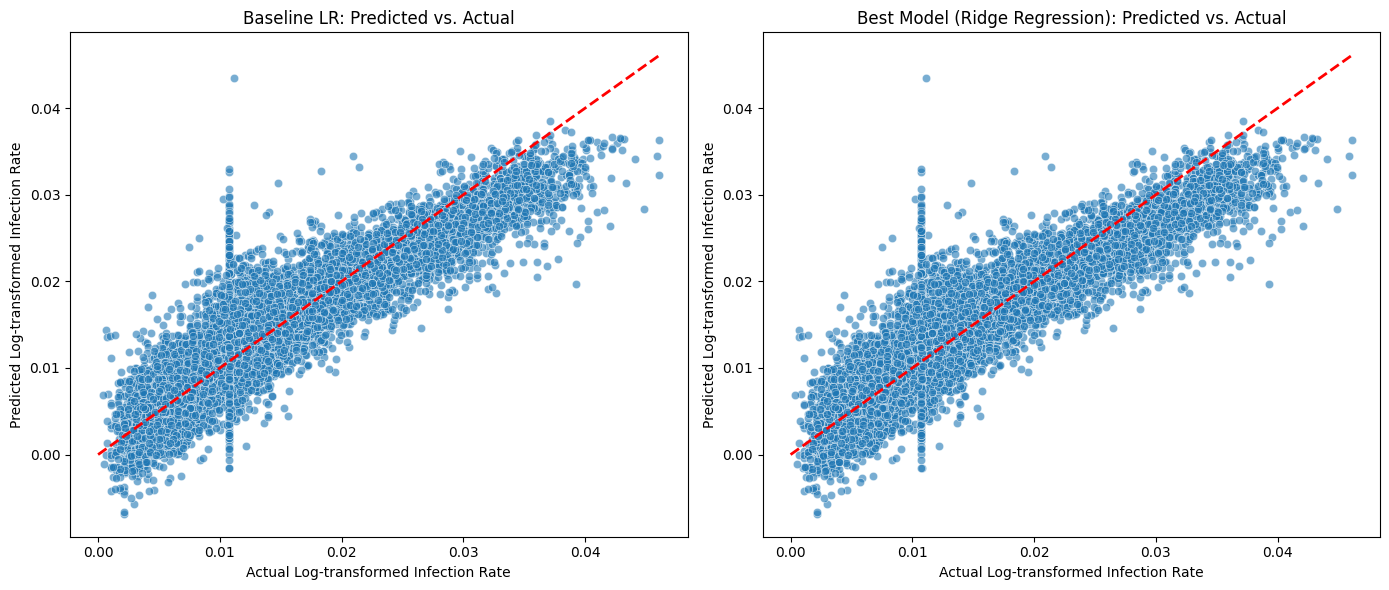

In [95]:
# Visualize to see if there are visual differences
model_objects = {
    'Linear Regression (Baseline)': lr_model, 
    'Ridge Regression': best_ridge,
    'Lasso Regression': best_lasso,
    'Elastic Net': best_en
}

bm_predictions = best_ridge.predict(X_test_scaled)
plot_df = pd.DataFrame({
    'Actual_Log_Infection': y_test,
    'Baseline_LR_Pred': lr_predictions,
    'Advanced_LR_Pred': bm_predictions
})

#### Baseline LR
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Actual_Log_Infection', y='Baseline_LR_Pred', data=plot_df, alpha=0.6)
# Plot the ideal 45-degree line (Actual == Predicted)
max_val = plot_df['Actual_Log_Infection'].max()
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2) 
plt.title('Baseline LR: Predicted vs. Actual')
plt.xlabel('Actual Log-transformed Infection Rate')
plt.ylabel('Predicted Log-transformed Infection Rate')

# Best Model
plt.subplot(1, 2, 2)
sns.scatterplot(x='Actual_Log_Infection', y='Advanced_LR_Pred', data=plot_df, alpha=0.6)
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2)
plt.title(f'Best Model ({best_model_name}): Predicted vs. Actual')
plt.xlabel('Actual Log-transformed Infection Rate')
plt.ylabel('Predicted Log-transformed Infection Rate')

plt.tight_layout()
plt.show()

We can see that visually, the scatterplots look the same which further supports our conclusion that the original model was already robust and required no additional complexity reduction or shrinkage.

In [98]:
# Check for top 5 drivers 
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_ridge.coef_
})

coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)
print(f"Top 5 Impactful Cyber Threat Drivers (Model: {best_model_name})")
print(coefficients[['Feature', 'Coefficient']].head().to_string(index=False))

# Check the features that lasso has dropped
zero_threshold = 1e-6
eliminated_features = coefficients[coefficients['Abs_Coefficient'] < zero_threshold]
if not eliminated_features.empty:
    print(f"\nFeatures Effectively Eliminated ({len(eliminated_features)}):")
    print(eliminated_features['Feature'].to_string(index=False))
else:
    print("\nNo features were eliminated (coefficients were not forced to zero).")


Top 5 Impactful Cyber Threat Drivers (Model: Ridge Regression)
           Feature  Coefficient
    Log_Web_Threat     0.008029
  Log_Web_Threat^2    -0.004023
       Log_Exploit     0.002713
Log_Network_Attack     0.002608
Log_Malicious_Mail     0.002549

Features Effectively Eliminated (2):
Åland Islands
      Grenada


We can see above that the top 5 impactful drivers between the linear regression model (check the baseline regression model notebook) is essentially the same as what we got for ridge. Further confirming that the cleaned and transformed data has allowed the simple linear regression model to be stable and accurate with a rsquared of 0.848593 meaning the model effectively captures or explains 84.85% of the variance. 

All recommendations and insights on the baseline regression model should be the same given the similar results.